### Импорт библиотек

In [35]:
import trino
import pandas as pd
import matplotlib.pyplot as plt

# Настройка отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Либы успешно импортированы")

Либы успешно импортированы


### Подключение к Trino

In [4]:
# Подключение к Trino

conn = trino.dbapi.connect(
    # host="host.docker.internal" еслиv не в одной docker-сети, иначе прост host="trino"
    host="trino",
    port=8080,
    user="student",
    catalog="iceberg",
    schema="demo",
)
cur = conn.cursor()

# Вспомогательная функция для выполнения запросов
def q(sql):
    """Дергает запрос и вывод в виде df"""
    cur.execute(sql)
    rows = cur.fetchall()
    return pd.DataFrame(rows, columns=[c[0] for c in cur.description]) if cur.description else None

# Проверка подключения
result = q("SELECT 'Подключение к trino успешно' AS status")
print(result)

                        status
0  Подключение к trino успешно


### Проверка каталогов Postgres и Mysql

In [19]:
# Список схем Postgres
print("\nСхемы в PostgreSQL:")
pg_schemas = q("SHOW SCHEMAS FROM postgres")
print(pg_schemas)

# Список таблиц в схеме public
print("\nТаблицы в postgres.public:")
pg_tables = q("SHOW TABLES FROM postgres.public")
print(pg_tables)

# MYSQL
print("MYSQL - Проверка каталога")

# Список схем Mysql
print("\n Схемы в MySQL:")
mysql_schemas = q("SHOW SCHEMAS FROM mysql")
print(mysql_schemas)

# Список таблиц в схеме demo_db
print("\nТаблицы в mysql.demo_db:")
mysql_tables = q("SHOW TABLES FROM mysql.demo_db")
print(mysql_tables)


Схемы в PostgreSQL:
               Schema
0  information_schema
1          pg_catalog
2              public

Таблицы в postgres.public:
           Table
0  trn_customers
1     trn_orders
MYSQL - Проверка каталога

 Схемы в MySQL:
               Schema
0             demo_db
1  information_schema
2  performance_schema

Таблицы в mysql.demo_db:
          Table
0  trn_payments


In [17]:
print("Таблицы в postgres.public:")
print(q("SHOW TABLES FROM postgres.public"))

Таблицы в postgres.public:
           Table
0  trn_customers
1     trn_orders


### Наполнение данными Postgres по заказам

In [16]:
print("Наполнение Postgres данными о заказах")

# Проверка кол-ва записей до вставки
before_count = q("SELECT COUNT(*) as cnt FROM postgres.public.trn_orders")
print(f"\nЗаписей до вставки: {before_count['cnt'].iloc[0]}")

# Вставка данных о заказах (9к записей)
insert_orders_sql = """
INSERT INTO postgres.public.trn_orders (order_id, customer_id, order_ts, total_amount)
WITH max_order AS (
  SELECT COALESCE(MAX(order_id), 0) AS max_id
  FROM postgres.public.trn_orders
),
c AS (
  SELECT customer_id, row_number() OVER (ORDER BY customer_id) AS rn
  FROM postgres.public.trn_customers
),
cnt AS (SELECT MAX(rn) AS n FROM c),
gen AS (
  SELECT
    (max_id + x) AS order_id,
    x
  FROM max_order
  CROSS JOIN UNNEST(sequence(1, 9000)) AS t(x)
)
SELECT
  gen.order_id,
  c.customer_id,
  current_timestamp
    - INTERVAL '1' DAY * CAST(rand() * 730 AS integer)
    - INTERVAL '1' MINUTE * CAST(rand() * 1440 AS integer) AS order_ts,
  round(10 + rand() * 990, 2) AS total_amount
FROM gen
CROSS JOIN cnt
JOIN c ON c.rn = ((gen.x - 1) % cnt.n) + 1
"""

try:
    q(insert_orders_sql)
    print("Данные о заказах успешно вставлены")
except Exception as e:
    print(f"Ошибка при вставке (возможно данные уже есть): {e}")

# Проверка кол-ва записей после вставки
after_count = q("SELECT COUNT(*) as cnt FROM postgres.public.trn_orders")
print(f"Записей после вставки: {after_count['cnt'].iloc[0]}")

# Пример данных
print("\n Пример данных из trn_orders (последние 5):")
orders_sample = q("""
    SELECT * FROM postgres.public.trn_orders 
    ORDER BY order_ts DESC 
    LIMIT 5
""")
print(orders_sample)

Наполнение Postgres данными о заказах

Записей до вставки: 0
Данные о заказах успешно вставлены
Записей после вставки: 9000

 Пример данных из trn_orders (последние 5 записей):
   order_id  customer_id                order_ts total_amount
0      3919            9 2026-01-14 00:44:34.384       984.78
1      1069            9 2026-01-13 20:22:34.384       802.09
2      6453            3 2026-01-13 18:39:34.384       272.16
3      3777            7 2026-01-13 14:43:34.384       560.66
4      8078            8 2026-01-13 10:43:34.384       743.66


### Наполнение данными MySQL по платежам

In [18]:
print("Наполнение mysql данными о платежах")

# Проверка кол-ва записей до вставки
before_payments = q("SELECT COUNT(*) as cnt FROM mysql.demo_db.trn_payments")
print(f"\nЗаписей до вставки: {before_payments['cnt'].iloc[0]}")

# Вставка данных о платежах
insert_payments_sql = """
INSERT INTO mysql.demo_db.trn_payments (payment_id, order_id, amount, paid_at)
WITH max_ids AS (
  SELECT
    COALESCE((SELECT MAX(order_id) FROM postgres.public.trn_orders), 0) AS max_order_id,
    COALESCE((SELECT MAX(order_id) FROM postgres.public.trn_orders), 0) - 9000 AS prev_max_order_id,
    COALESCE((SELECT MAX(payment_id) FROM mysql.demo_db.trn_payments), 0) AS max_payment_id
),
o AS (
  SELECT
    t.order_id,
    t.total_amount,
    t.order_ts,
    row_number() OVER (ORDER BY t.order_id) AS rn
  FROM postgres.public.trn_orders t
  CROSS JOIN max_ids m
  WHERE t.order_id > m.prev_max_order_id
),
paid_orders AS (
  SELECT * FROM o WHERE rn % 10 NOT IN (0,1,2)
),
two_payments AS (
  SELECT * FROM paid_orders WHERE rn % 4 = 0
),
one_payment AS (
  SELECT * FROM paid_orders WHERE rn % 4 != 0
),
p1 AS (
  SELECT
    CAST(rn * 10 + 1 AS bigint) AS local_pid,
    CAST(order_id AS bigint) AS order_id,
    round(total_amount * (0.4 + rand() * 0.4), 2) AS amount,
    order_ts + INTERVAL '1' DAY * CAST(1 + rand() * 3 AS integer) AS paid_at
  FROM two_payments
),
p2 AS (
  SELECT
    CAST(tp.rn * 10 + 2 AS bigint) AS local_pid,
    CAST(tp.order_id AS bigint) AS order_id,
    round(tp.total_amount - p1.amount, 2) AS amount,
    tp.order_ts + INTERVAL '1' DAY * CAST(4 + rand() * 5 AS integer) AS paid_at
  FROM two_payments tp
  JOIN p1 ON p1.order_id = CAST(tp.order_id AS bigint)
),
p_full AS (
  SELECT
    CAST(rn * 10 + 3 AS bigint) AS local_pid,
    CAST(order_id AS bigint) AS order_id,
    round(total_amount * (0.95 + rand() * 0.15), 2) AS amount,
    order_ts + INTERVAL '1' DAY * CAST(1 + rand() * 7 AS integer) AS paid_at
  FROM one_payment
),
all_p AS (
  SELECT * FROM p1
  UNION ALL SELECT * FROM p2
  UNION ALL SELECT * FROM p_full
)
SELECT
  CAST(m.max_payment_id + all_p.local_pid AS bigint) AS payment_id,
  all_p.order_id,
  all_p.amount,
  CAST(all_p.paid_at AS timestamp(3)) AS paid_at
FROM all_p
CROSS JOIN max_ids m
"""

try:
    q(insert_payments_sql)
    print("Данные о платежах успешно вставлены")
except Exception as e:
    print(f"Ошибка при вставке (хз, может данные уже есть): {e}")

# Проверка количества записей после вставки
after_payments = q("SELECT COUNT(*) as cnt FROM mysql.demo_db.trn_payments")
print(f"Записей после вставки: {after_payments['cnt'].iloc[0]}")

# Пример данных
print("\n Пример данных из trn_payments (последние 5):")
payments_sample = q("""
    SELECT * FROM mysql.demo_db.trn_payments 
    ORDER BY paid_at DESC 
    LIMIT 5
""")
print(payments_sample)

Наполнение mysql данными о платежах

Записей до вставки: 0
Данные о платежах успешно вставлены
Записей после вставки: 7650

 Пример данных из trn_payments (последние 5):
   payment_id  order_id  amount                   paid_at
0       18543      1854  526.53 2026-01-21 09:10:34+00:00
1       32042      3204  226.70 2026-01-20 18:18:34+00:00
2       37773      3777  549.75 2026-01-19 14:43:34+00:00
3       15393      1539  810.97 2026-01-19 11:41:34+00:00
4       14773      1477  834.42 2026-01-18 23:10:34+00:00


### Агрегация данных

#### Агрегация заказов по дням (Postgres)

In [20]:
print("Источник: postgres.public.trn_orders")

df_orders_daily = q("""
SELECT
  date_trunc('day', order_ts) as dt,
  count(*) as orders_cnt,
  sum(total_amount) as revenue
FROM postgres.public.trn_orders
GROUP BY 1
ORDER BY 1
""")

print(f"\nПолучено {len(df_orders_daily)} записей")
print("\nПервые 10 строк:")
print(df_orders_daily.head(10))

print("\nСтата по заказам:")
print(df_orders_daily[['orders_cnt', 'revenue']].describe())

Источник: postgres.public.trn_orders

Получено 732 записей

Первые 10 строк:
          dt  orders_cnt  revenue
0 2024-01-14           3   890.88
1 2024-01-15          12  5753.71
2 2024-01-16          10  6589.88
3 2024-01-17          12  4480.36
4 2024-01-18           8  3837.05
5 2024-01-19          10  4617.28
6 2024-01-20          14  7166.65
7 2024-01-21           9  5606.48
8 2024-01-22          11  4028.65
9 2024-01-23           5  2901.77

Стата по заказам:
       orders_cnt
count  732.000000
mean    12.295082
std      3.487375
min      1.000000
25%     10.000000
50%     12.000000
75%     15.000000
max     25.000000


#### Агрегация платежей по дням (MySQL)

In [21]:
print("Источник: mysql.demo_db.trn_payments")

df_payments_daily = q("""
SELECT 
  date_trunc('day', paid_at) as dt,
  count(*) as payments_cnt,
  sum(amount) as paid_amount
FROM mysql.demo_db.trn_payments
GROUP BY 1
ORDER BY 1
""")

print(f"\nПолучено {len(df_payments_daily)} записей")
print("\nПервые 10 строк:")
print(df_payments_daily.head(10))

print("\nСтата по платежам:")
print(df_payments_daily[['payments_cnt', 'paid_amount']].describe())

Источник: mysql.demo_db.trn_payments

Получено 737 записей

Первые 10 строк:
                         dt  payments_cnt paid_amount
0 2024-01-16 00:00:00+00:00             1      645.86
1 2024-01-17 00:00:00+00:00             2      629.79
2 2024-01-18 00:00:00+00:00             3     1428.62
3 2024-01-19 00:00:00+00:00             4     2326.80
4 2024-01-20 00:00:00+00:00             5     2227.97
5 2024-01-21 00:00:00+00:00            12     4977.27
6 2024-01-22 00:00:00+00:00             7     1614.10
7 2024-01-23 00:00:00+00:00            10     5231.55
8 2024-01-24 00:00:00+00:00            10     5495.72
9 2024-01-25 00:00:00+00:00             6     2245.38

Стата по платежам:
       payments_cnt
count    737.000000
mean      10.379919
std        3.329631
min        1.000000
25%        8.000000
50%       10.000000
75%       13.000000
max       20.000000


### итоговый dataframe

In [23]:
import pandas as pd

# Приведение дат
df_orders_daily['dt'] = pd.to_datetime(df_orders_daily['dt'], utc=True).dt.tz_localize(None)
df_payments_daily['dt'] = pd.to_datetime(df_payments_daily['dt'], utc=True).dt.tz_localize(None)

# Теперь мердж
df_final = df_orders_daily.merge(
    df_payments_daily, 
    on="dt", 
    how="left"
).fillna({
    "payments_cnt": 0, 
    "paid_amount": 0
})

# расчёт кэфа покрытия платежами
# чек на деление на ноль, чтобы не получать inf или NaN
df_final['payment_coverage'] = df_final.apply(
    lambda x: x['paid_amount'] / x['revenue'] if x['revenue'] > 0 else 0, 
    axis=1
)

# Сортировка
df_final = df_final.sort_values('dt').reset_index(drop=True)

print("\nСтруктура DataFrame:")
print(df_final.dtypes)

print("\nПервые 10 строк:")
display(df_final.head(10))

print("\nОбщая статистика:")
display(df_final.describe())


Структура DataFrame:
dt                  datetime64[ns]
orders_cnt                   int64
revenue                     object
payments_cnt               float64
paid_amount                 object
payment_coverage            object
dtype: object

Первые 10 строк:


,dt,orders_cnt,revenue,payments_cnt,paid_amount,payment_coverage
0,2024-01-14,3,890.88,0.0,0,0E+2
1,2024-01-15,12,5753.71,0.0,0,0E+2
2,2024-01-16,10,6589.88,1.0,645.86,0.09800785446775965571451983951
3,2024-01-17,12,4480.36,2.0,629.79,0.1405668294512048138988831255
4,2024-01-18,8,3837.05,3.0,1428.62,0.3723224873275042024471925047
5,2024-01-19,10,4617.28,4.0,2326.80,0.5039330514935199944556102294
6,2024-01-20,14,7166.65,5.0,2227.97,0.3108802578610647931739376138
7,2024-01-21,9,5606.48,12.0,4977.27,0.8877709364877784278192377392
8,2024-01-22,11,4028.65,7.0,1614.10,0.4006553063681382100703709679
9,2024-01-23,5,2901.77,10.0,5231.55,1.802882378686112269407982025



Общая статистика:


,dt,orders_cnt,payments_cnt
count,732,732.000000,732.000000
mean,2025-01-13 12:00:00.000000256,12.295082,10.416667
min,2024-01-14 00:00:00,1.000000,0.000000
25%,2024-07-14 18:00:00,10.000000,8.000000
50%,2025-01-13 12:00:00,12.000000,10.000000
75%,2025-07-15 06:00:00,15.000000,13.000000
max,2026-01-14 00:00:00,25.000000,20.000000
std,NaN,3.487375,3.310208


## Визуализация

### График 1: Revenue по датам

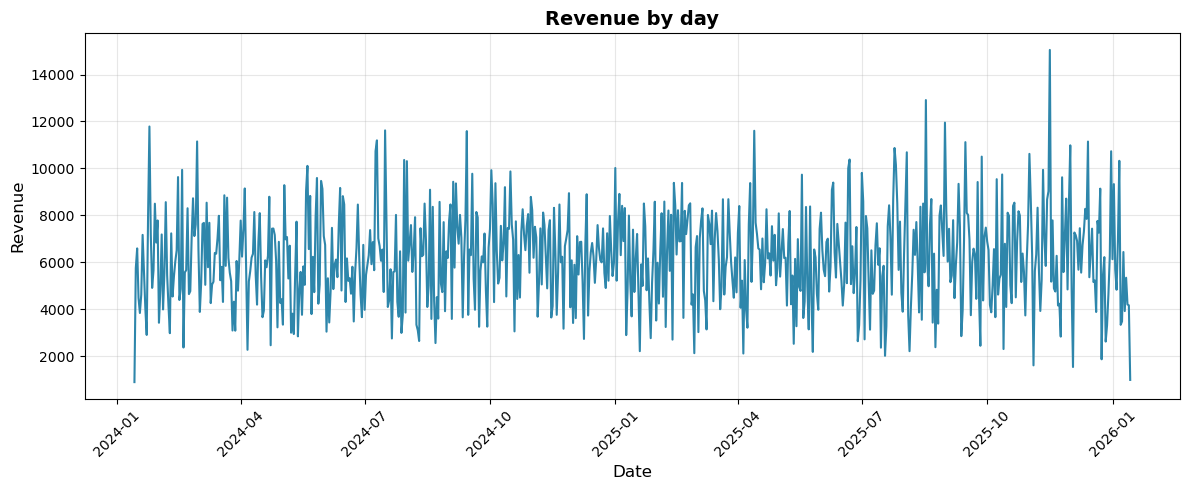

In [29]:
plt.figure(figsize=(12, 5))
plt.plot(df_final["dt"], df_final["revenue"], color='#2E86AB', linewidth=1.5)
plt.title("Revenue by day", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Revenue", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('/home/jovyan/work/revenue_by_day.png', dpi=150, bbox_inches='tight')
plt.show()

### График 2: Распределение payment_coverage

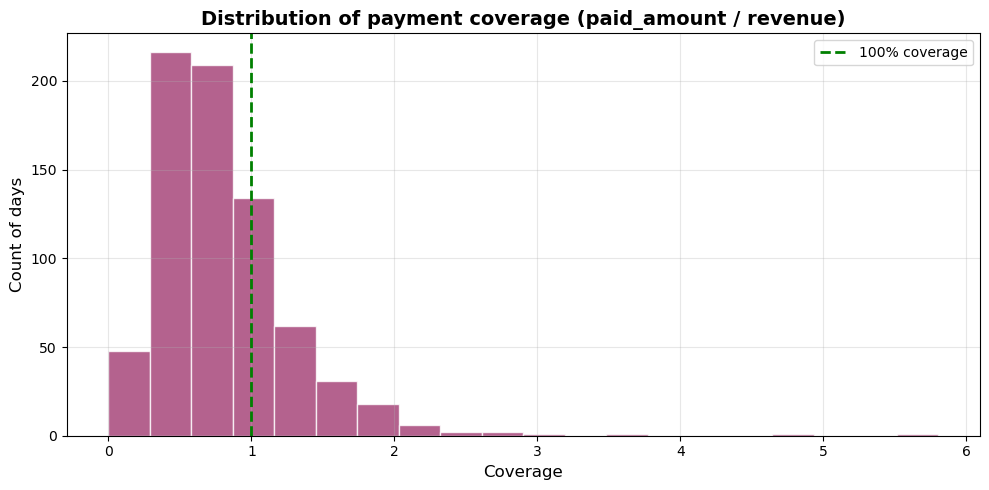

In [25]:
plt.figure(figsize=(10, 5))
plt.hist(df_final["payment_coverage"].dropna(), bins=20, color='#A23B72', edgecolor='white', alpha=0.8)
plt.title("Distribution of payment coverage (paid_amount / revenue)", fontsize=14, fontweight='bold')
plt.xlabel("Coverage", fontsize=12)
plt.ylabel("Count of days", fontsize=12)
plt.axvline(x=1.0, color='green', linestyle='--', linewidth=2, label='100% coverage')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('/home/jovyan/work/payment_coverage_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## Работа с iceberg

#### Так как я переводил Iceberg с Hive на PostgreSql, нужно спрерва создать две таблицы для хранения метаданных

In [79]:
# таблица для хранения списков таблиц Iceberg

try:
    q("DROP TABLE IF EXISTS postgres.public.iceberg_tables")
    q("""
    CREATE TABLE postgres.public.iceberg_tables (
        catalog_name VARCHAR(255),
        table_namespace VARCHAR(255),
        table_name VARCHAR(255),
        metadata_location VARCHAR(1000),
        previous_metadata_location VARCHAR(1000)
    )
    """)
    print("Таблица iceberg_tables создана")
except Exception as e:
    print(f"Ошибка tables: {e}")

# Таблица iceberg_namespace_properties
try:
    q("DROP TABLE IF EXISTS postgres.public.iceberg_namespace_properties")
    q("""
    CREATE TABLE postgres.public.iceberg_namespace_properties (
        catalog_name VARCHAR(255),
        namespace VARCHAR(255),
        property_key VARCHAR(255),
        property_value VARCHAR(1000)
    )
    """)
    print("Таблица iceberg_namespace_properties создана")
except Exception as e:
    print(f"Ошибка properties: {e}")

Таблица iceberg_tables создана
Таблица iceberg_namespace_properties создана


### Создание схемы в Iceberg

In [85]:
# Создание схемы
try:
    q("CREATE SCHEMA IF NOT EXISTS iceberg.student_analytics")
    print("Схема создана")
except Exception as e:
    print(f"Info: {e}")

# Создание таблицы
# Location тут: s3://warehouse/student_analytics/
create_table_sql = """
CREATE TABLE IF NOT EXISTS iceberg.student_analytics.daily_revenue_summary (
    dt DATE,
    orders_cnt BIGINT,
    revenue DOUBLE,
    avg_order_value DOUBLE,
    payments_cnt BIGINT,
    paid_amount DOUBLE,
    avg_payment DOUBLE,
    payment_coverage DOUBLE,
    unpaid_amount DOUBLE
)
WITH (
    format = 'PARQUET',
    partitioning = ARRAY['month(dt)']
)
"""

try:
    q(create_table_sql)
    print("Таблица успешно создана!")
except Exception as e:
    print(f"Ошибка: {e}")

# Генерация sql и запись
values_list = []

for index, row in df_final.iterrows():
    revenue = float(row['revenue'])
    paid_amount = float(row['paid_amount'])
    orders_cnt = int(row['orders_cnt'])
    payments_cnt = int(row['payments_cnt'])
    
    avg_ord = revenue / orders_cnt if orders_cnt > 0 else 0.0
    avg_pay = paid_amount / payments_cnt if payments_cnt > 0 else 0.0
    unpaid = revenue - paid_amount
    payment_coverage = row['payment_coverage'] # Это уже float
    
    # Формат даты
    dt_str = row['dt'].strftime('%Y-%m-%d')
    
    val = f"(DATE '{dt_str}', {orders_cnt}, {revenue:.2f}, {avg_ord:.2f}, {payments_cnt}, {paid_amount:.2f}, {avg_pay:.2f}, {payment_coverage:.4f}, {unpaid:.2f})"
    values_list.append(val)

print(f"Сформировано {len(values_list)} строк")

# Вставка батчами
if values_list:
    chunk_size = 50
    for i in range(0, len(values_list), chunk_size):
        chunk = values_list[i:i + chunk_size]
        sql = f"INSERT INTO iceberg.student_analytics.daily_revenue_summary VALUES {', '.join(chunk)}"
        try:
            q(sql)
        except Exception as e:
            print(f"\nОшибка при вставке батча {i}: {e}")
            break
    print("\nДанные успешно записаны в Iceberg")
else:
    print("Нет данных для записи")

# проверка
try:
    df_result = q("SELECT * FROM iceberg.student_analytics.daily_revenue_summary ORDER BY dt DESC LIMIT 10")
    display(df_result)
except Exception as e:
    print(f"Ошибка выборки: {e}")

# итоговая проверка
display(q("SELECT * FROM iceberg.student_analytics.daily_revenue_summary ORDER BY dt DESC LIMIT 5"))

Схема создана
Таблица успешно создана!
Сформировано 732 строк

Данные успешно записаны в Iceberg


,dt,orders_cnt,revenue,avg_order_value,payments_cnt,paid_amount,avg_payment,payment_coverage,unpaid_amount
0,2026-01-14,1,984.78,984.78,13,5716.31,439.72,5.8047,-4731.53
1,2026-01-14,1,984.78,984.78,13,5716.31,439.72,5.8047,-4731.53
2,2026-01-14,1,984.78,984.78,13,5716.31,439.72,5.8047,-4731.53
3,2026-01-14,1,984.78,984.78,13,5716.31,439.72,5.8047,-4731.53
4,2026-01-13,7,4163.47,594.78,11,5542.12,503.83,1.3311,-1378.65
5,2026-01-13,7,4163.47,594.78,11,5542.12,503.83,1.3311,-1378.65
6,2026-01-13,7,4163.47,594.78,11,5542.12,503.83,1.3311,-1378.65
7,2026-01-13,7,4163.47,594.78,11,5542.12,503.83,1.3311,-1378.65
8,2026-01-12,9,4199.86,466.65,12,6245.09,520.42,1.4870,-2045.23
9,2026-01-12,9,4199.86,466.65,12,6245.09,520.42,1.4870,-2045.23


,dt,orders_cnt,revenue,avg_order_value,payments_cnt,paid_amount,avg_payment,payment_coverage,unpaid_amount
0,2026-01-14,1,984.78,984.78,13,5716.31,439.72,5.8047,-4731.53
1,2026-01-14,1,984.78,984.78,13,5716.31,439.72,5.8047,-4731.53
2,2026-01-14,1,984.78,984.78,13,5716.31,439.72,5.8047,-4731.53
3,2026-01-14,1,984.78,984.78,13,5716.31,439.72,5.8047,-4731.53
4,2026-01-13,7,4163.47,594.78,11,5542.12,503.83,1.3311,-1378.65


# УРА!!!